In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

foldername='Results'
if not os.path.exists(foldername):
    os.makedirs(foldername)
    

In [2]:
# define prelisted paraters for the simautlion 
s0=100
k=np.linspace(80,110,6)
r=0.06
sigma=0.16
Duration=np.linspace(1,5,5)
noofpaths=1000
noofsteps=100


In [3]:
# Defining the monte carlo simualtion main fucntion with the normal simulation and control variates



def monte_carlo_simulation(s0,k,r,sigma,duration,noofpaths,noofsteps):
    Results={}
    dt=duration/noofsteps
    paths=np.zeros((noofpaths,noofsteps+1))
    z=np.random.normal(0,1,(noofpaths,noofsteps))
    time=np.zeros((noofsteps+1))
    time[0]=0
    paths[:,0]=s0
    for i in range(noofsteps):
        z[:,i]=(z[:,i]-np.mean(z[:,i]))/np.std(z[:,i],ddof=1)
        paths[:,i+1] = paths[:,i] + paths[:,i]*r*dt + paths[:,i]*sigma*z[:,i]*np.sqrt(dt)
        time[i+1]=time[i]+dt
    Results['paths']=paths
    Results['Terminal']=paths[:,-1]
    Results['time']=time
    return Results 

def pricing(type,method,s0,k,r,sigma,duration,noofpaths,noofsteps):
    type=type.lower()
    method=method.lower()
    paths=monte_carlo_simulation(s0,k,r,sigma,duration,noofpaths,noofsteps)['paths']
    st=paths[:,-1]
    payoff_call = np.exp(-r*duration)*np.maximum(st-k,0)
    payoff_put =  np.exp(-r*duration)*np.maximum(k-st,0)
    lambda_call = ((np.cov(payoff_call,st))/np.std(st))[0,1]
    lambda_put = ((np.cov(payoff_put,st))/np.std(st))[0,1]
    E_st = s0*np.exp(r*duration)
    price = 0
    if method=='normal':
        if type=='call':
            price = np.exp(-r*duration)*np.mean(np.maximum(st-k,0))
        elif type=='put':
            price = np.exp(-r*duration)*np.mean(np.maximum(k-st,0))
    elif method == 'control_variate':
        if type == 'call':
            payoff_call = payoff_call + lambda_call*(E_st-st)
            price = np.mean(payoff_call)
        elif type == 'put':
            payoff_put = payoff_put + lambda_call*(E_st-st)
            price = np.mean(payoff_put)
    return price
            
def error(type,method,s0,k,r,sigma,duration,noofpaths,noofsteps):
    results={}
    price_1 = pricing(type,'normal',s0,k,r,sigma,duration,noofpaths,noofsteps)
    price_2 = pricing(type,'control_variate',s0,k,r,sigma,duration,noofpaths,noofsteps)
    err = np.abs(price_1 - price_2)
    err_p = (err/(np.maximum(price_1,price_2)))*100
    results['error']= err
    results['error%'] = err_p
    return results

In [4]:
pricing('call','control_variate',100,80,0.06,0.10,2,1000,100)
error('call','control_variate',100,80,0.06,0.10,2,1000,100)['error%']



np.float64(2.4765073665302477)

In [5]:
Data_0 = pd.DataFrame(index=range(len(k)),columns=range(len(Duration)))
Data_1 = pd.DataFrame().reindex_like(Data_0)
Error = pd.DataFrame().reindex_like(Data_0)
for j in range(len(Duration)):
    Data_0[j] = [pricing('call','normal',s0,i,r,sigma,Duration[j],noofpaths,noofsteps) for i in k ]
    Data_1[j] = [pricing('call','control_variate',s0,i,r,sigma,Duration[j],noofpaths,noofsteps) for i in k]
    Error [j] = (np.abs(Data_0[j] - Data_1[j]))/(np.maximum(Data_0[j],Data_1[j]))
    

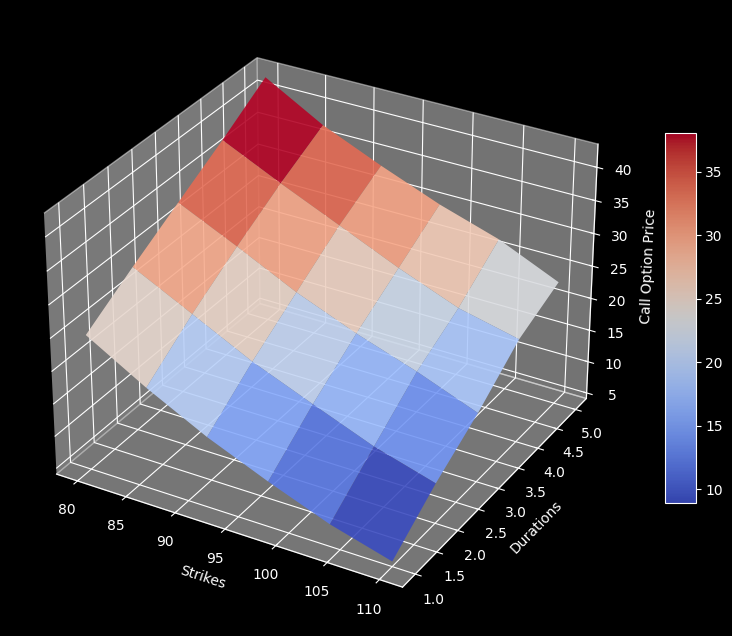

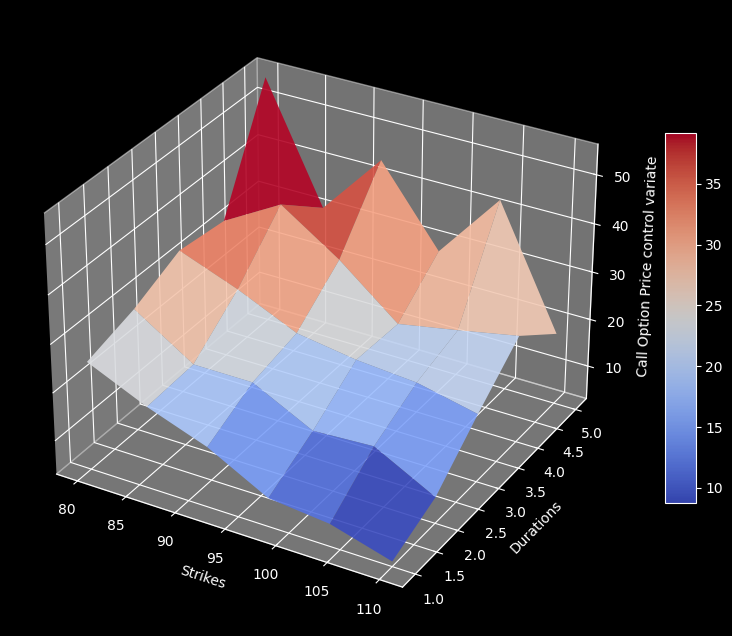

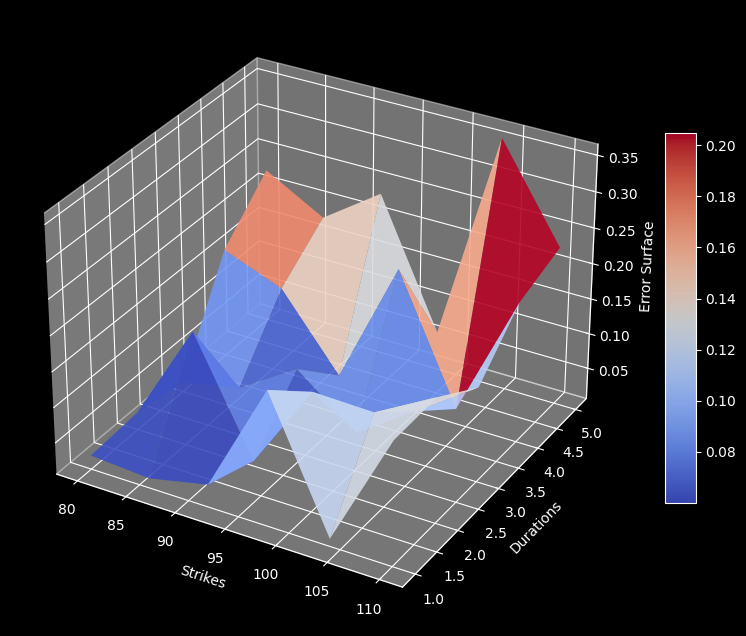

In [6]:
# plotting the given plots Option prices for the nromal bs methid and the control variate etchiwues and th error plots for bitht he techniques 

x,y=np.meshgrid(k,Duration)
price_0 = Data_0.values.T
price_1 = Data_1.values.T
Error = Error.T

# plottin the option price using noral method and monte carlo siulaton
plt.style.use('dark_background')
fig=plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(x, y, price_0, cmap=cm.coolwarm,alpha=0.9,rstride=1,cstride=1)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12)

# Label axes
ax.set_xlabel('Strikes')
ax.set_ylabel('Durations')
ax.set_zlabel('Call Option Price')
file_name='3d plot for option price normal gbm monte carlo simulation'
file_path=os.path.join(foldername,file_name)
plt.savefig(file_path,bbox_inches='tight',dpi=300)



# plottin the option pricxes using the conteol variate methodf 
plt.style.use('dark_background')
fig=plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(x, y, price_1, cmap=cm.coolwarm,alpha=0.9,rstride=1,cstride=1)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12)

# Label axes
ax.set_xlabel('Strikes')
ax.set_ylabel('Durations')
ax.set_zlabel('Call Option Price control variate')
file_name='3d plot for option price using control variate  gbm monte carlo simulation'
file_path=os.path.join(foldername,file_name)
plt.savefig(file_path,bbox_inches='tight',dpi=300)

# 3 d plott for the erro surafce between the normal option price and the control varate price 
plt.style.use('dark_background')
fig=plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(x, y, Error, cmap=cm.coolwarm,alpha=0.9,rstride=1,cstride=1)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12)

# Label axes
ax.set_xlabel('Strikes')
ax.set_ylabel('Durations')
ax.set_zlabel('Error Surface')
file_name='3d plot for realtive Error function for the pricing methods'
file_path=os.path.join(foldername,file_name)
plt.savefig(file_path,bbox_inches='tight',dpi=300)

In [8]:
file_name='Call_Price using Normal Monte carlo simulation.csv'
file_name_1='Call_Price using control variate monte carlo simulation.csv'
file_name_2='Error values between pricing methods.csv'

file_path=os.path.join(foldername,file_name)
file_path_1=os.path.join(foldername,file_name_1)
file_path_2=os.path.join(foldername,file_name_2)

Data_0.to_csv(file_path)
Data_1.to_csv(file_path_1)
Error=pd.DataFrame(Error.T,index=range(len(k)),columns=range(len(Duration)))
Error.to_csv(file_path_2)